In [38]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import vortexwake.vortexwake as vw


# 2D Free-Vortex Wake Example

## Initialisation and simple forward simulation

Configuration can be provided as a Python `dict` or loaded from a `.json` configuration file.

In [2]:
fvw_config_2d = {'dimension': 2, 
                 'time_step': 0.2, 
                 'num_rings': 60, 
                 'num_turbines': 1, 
                 'num_virtual_turbines': 1,
                 'turbine_positions': [[0, 0], [5, 0]],
                 'vortex_core_size': 0.1}

Initialise the free-vortex wake model with the configuration `dict`

In [4]:
fvw = vw.VortexWake2D(fvw_config_2d)

In [5]:
## initialisation with .json configuration file
# fvw_config_2d_file = "../config/base_2d.json"
# fvw = vw.VortexWake2D(fvw_config_2d_file)

The model state is initialised as a tuple of arrays and can be converted to a single state vector

In [6]:
states = fvw.initialise_states()
initial_state_vector = fvw.state_vector_from_states(*states)

For running a simple simulation over 200 steps

In [8]:
num_steps = 200

Specify the control signal for the entire simulation

In [9]:
controls = np.zeros((num_steps+1, fvw.total_controls))
# controls for the first turbine
controls[:, fvw.induction_idx] = 0.33
controls[:, fvw.yaw_idx] = 0.
# controls for the virtual turbine
controls[:, fvw.induction_idx + fvw.num_controls] = 0.33
controls[:, fvw.yaw_idx + fvw.num_controls] = 0.

The inflow can be specified independently for every time step, here initialised uniformly

In [11]:
inflow = np.zeros((num_steps, fvw.dim)) + fvw.unit_vector_x

Now the model is ready to run a simulation with the generated inputs. `.run_forward()` returns a tuple of state history and derivatives. For now, we are only interested in the state and not the tangent information

In [15]:
state_history = fvw.run_forward(initial_state_vector,
                     controls,
                     inflow,
                     num_steps,
                     with_tangent=False)[0]

In [25]:
final_state = state_history[-1]
final_controls = controls[-1]
# unpack final state
X,G,U,M = fvw.states_from_state_vector(final_state)

Given the final state, we can plot the vortex particles

Text(0, 0.5, 'y (-)')

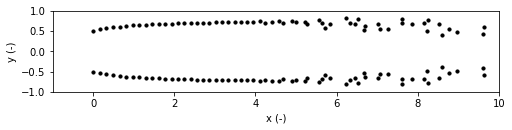

In [40]:
fig,ax = plt.subplots(1,1,figsize=(8,4))
for ring in range(fvw.num_rings):
    px = X[ring,:,0]
    py = X[ring,:,1]
    ax.scatter(px,py,c='k',s=10)
ax.set_xlim(-1,10)
ax.set_ylim(-1,1)
ax.set_aspect("equal")
ax.set_xlabel("x (-)")
ax.set_ylabel("y (-)")

Additionally, we can evalate the velocity on a dense grid of points to visualise the velocity magnitude

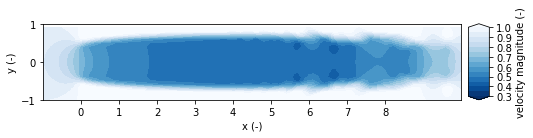

In [41]:
fig,ax = plt.subplots(1,1,figsize=(8,4))
xcoords = np.arange(-1,10.1,0.1)
ycoords = np.arange(-1,1.,0.1)
xgrid,ygrid = np.meshgrid(xcoords,ycoords)
xgrid = np.swapaxes(xgrid,0,1)
ygrid = np.swapaxes(ygrid,0,1)
points = np.array([xgrid,ygrid]).reshape(2,-1).T

velocity = fvw.velocity(final_state,
                        final_controls,
                        points,
                        with_tangent=False)[0]
velocity_norm = np.linalg.norm(velocity, axis=1)
velocity_norm = velocity_norm.reshape(len(xcoords), len(ycoords))

levels = np.linspace(0.3,1.,15)
c = ax.contourf(xgrid, ygrid, velocity_norm, cmap='Blues_r',levels=levels,extend="both")
ax.set_xlim(-1,10)
ax.set_ylim(-1,1)
ax.set_aspect("equal")
ax.set_xticks(np.arange(0,9))
ax.set_yticks([-1,0,1])
ax.set_xlabel("x (-)")
ax.set_ylabel("y (-)")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cb = plt.colorbar(c, cax=cax)
cb.set_label("velocity magnitude (-)")
cb.set_ticks(np.arange(0.3,1.05,0.1))

calculating a power signal?